In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/bstadt/root/tlm/models/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

/home/bstadt/root/tlm/tlmenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [3]:
from matplotlib import pyplot as plt
def pyear_given_slotfill(phrase, template, model, tokenizer, title, annotate=None, annotate_text=None, vlines=None, plot_template=False, plot_fill=False):
    years, fill_year_logits, fill_year_probs = lyear(phrase, model, tokenizer)
    _, template_year_logits, template_year_probs = lyear(template, model, tokenizer)
    bayes_factors = fill_year_probs/template_year_probs

    plt.figure()
    plt.title(title)
    plt.ylabel('Bayes Factor')
    plt.xlabel('Year')
    plt.plot(years, bayes_factors)
    plt.legend()

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], 0, annotate_text, ha='left', va='bottom')

    if vlines != None:
        for vline in vlines:
            plt.axvline(vline, color='red', linestyle='--')


    plt.show()

    if plot_fill:
        plt.plot(years, fill_year_probs, label='Fill')
        plt.legend()
        plt.show()

    if plot_template:
        plt.plot(years, template_year_probs, label='Template')
        plt.legend()
        plt.show()

    return bayes_factors

/tmp/ipykernel_3492936/2239432322.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


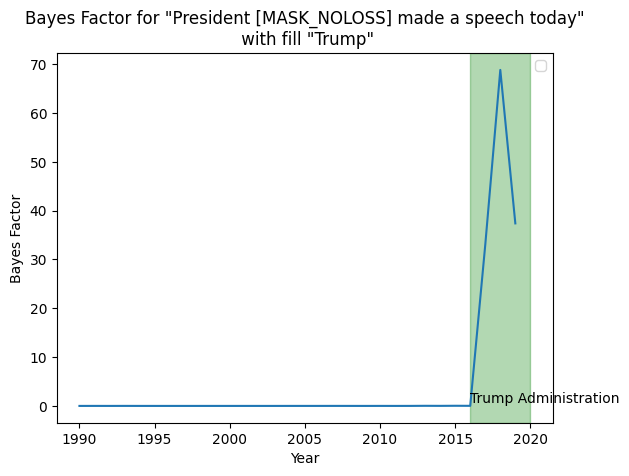

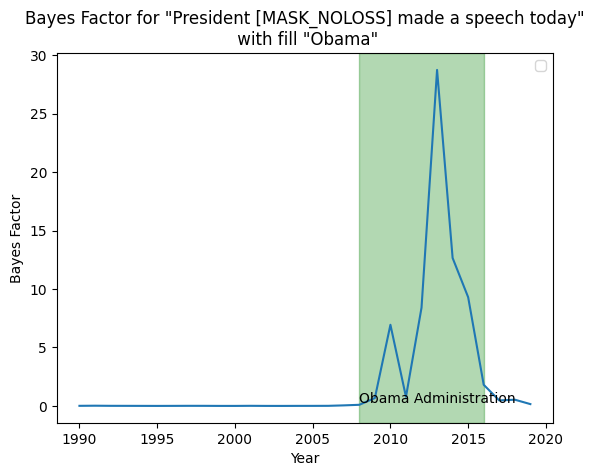

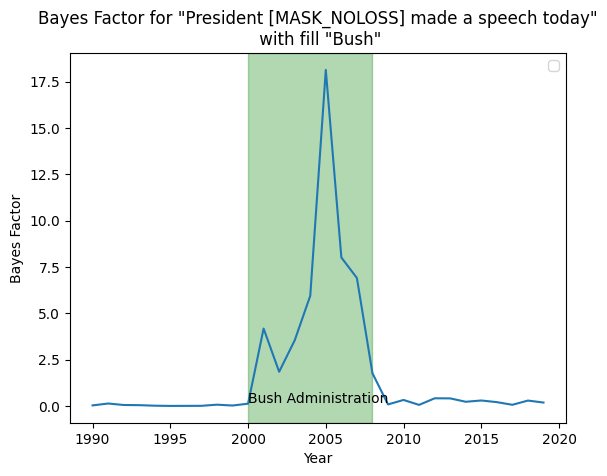

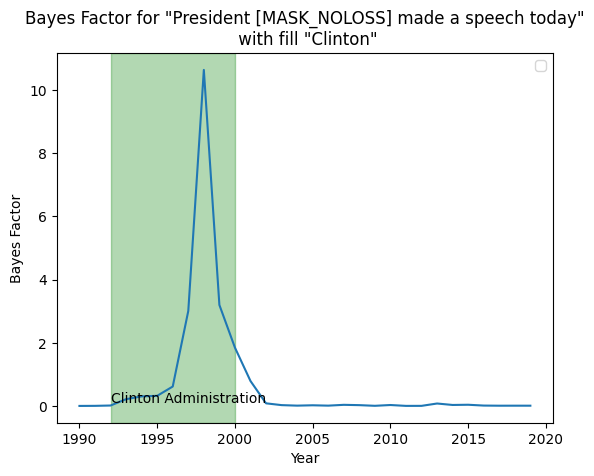

In [4]:
template = 'President [MASK_NOLOSS] made a speech today'
t_bayes = pyear_given_slotfill('President Trump made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Trump"',
 annotate=(2016, 2020), annotate_text='Trump Administration')
o_bayes = pyear_given_slotfill('President Obama made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Obama"',
 annotate=(2008, 2016), annotate_text='Obama Administration')
b_bayes = pyear_given_slotfill('President Bush made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Bush"',
 annotate=(2000, 2008), annotate_text='Bush Administration')
c_bayes = pyear_given_slotfill('President Clinton made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Clinton"',
 annotate=(1992, 2000), annotate_text='Clinton Administration')

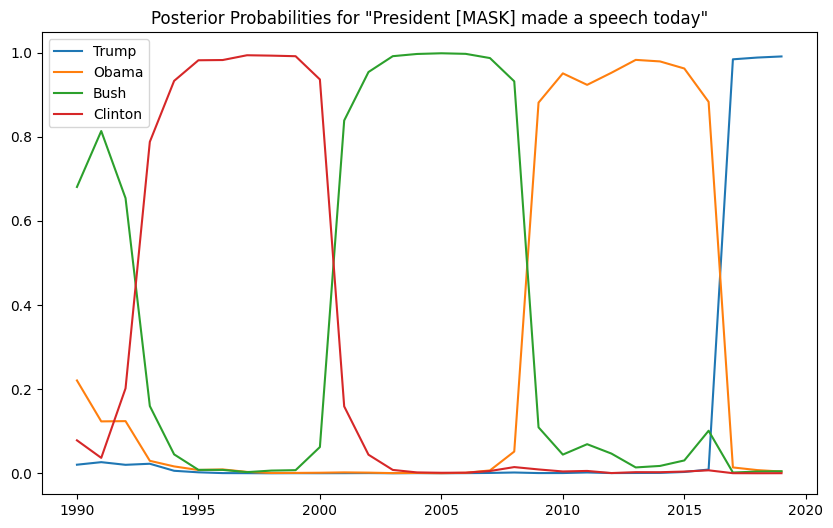

In [5]:
import numpy as np
all_bayes = np.stack([t_bayes, o_bayes, b_bayes, c_bayes])
posteriors = all_bayes/np.sum(all_bayes, axis=0)
years = list(range(1990, 2020))

plt.figure(figsize=(10, 6))
plt.title('Posterior Probabilities for "President [MASK] made a speech today"')
plt.plot(years, posteriors[0], label='Trump')
plt.plot(years, posteriors[1], label='Obama')
plt.plot(years, posteriors[2], label='Bush')
plt.plot(years, posteriors[3], label='Clinton')
plt.legend()
plt.show()

In [6]:
import torch
import torch.nn.functional as F
def l_fill(phrase, fill, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    phrases = ['[YEAR:{}]'.format(year) + ' ' + phrase for year in years]

    fill_token_ids = tokenizer.encode(fill, add_special_tokens=False)
    test_mask = tokenizer.encode(phrase, add_special_tokens=False, return_tensors='pt')
    n_masks = torch.where(test_mask==tokenizer.mask_token_id)[0].shape[0]
    if n_masks != len(fill_token_ids):
        raise ValueError(f"Number of mask tokens ({n_masks}) does not match number of fill token IDs ({len(fill_token_ids)})")
    
    inputs = tokenizer.batch_encode_plus(phrases, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids']==tokenizer.mask_token_id)

    with torch.no_grad():
        outputs = model(**inputs)
        fill_probs = []
        logits = outputs.logits[mask_locs]
        logits = logits.reshape(30, n_masks, -1)
        for i, fill_token_id in enumerate(fill_token_ids):
            fill_probs.append(F.softmax(logits[:, i, fill_token_id], dim=-1))

    return years, fill_probs

In [7]:
def get_top_fills(phrase, model, tokenizer, year=2000, top_k=5):
    """
    Get the top k most likely fills for a phrase with mask tokens.
    
    Args:
        phrase: String with [MASK] tokens to fill
        model: The language model
        tokenizer: The tokenizer
        year: Year to use for temporal context (default 2000)
        top_k: Number of top fills to return (default 5)
    
    Returns:
        List of tuples (fill_tokens, probability) for top k fills
    """
    model.eval()
    
    # Add year context
    phrase_with_year = f'[YEAR:{year}] {phrase}'
    
    # Tokenize and find mask positions
    inputs = tokenizer.encode_plus(phrase_with_year, add_special_tokens=False, return_tensors='pt')
    mask_locs = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1]
    n_masks = len(mask_locs)
    
    if n_masks == 0:
        raise ValueError("No mask tokens found in phrase")
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0]  # Remove batch dimension
        
        # Get logits for each mask position
        mask_logits = logits[mask_locs]  # Shape: (n_masks, vocab_size)
        
        # Convert to probabilities
        mask_probs = F.softmax(mask_logits, dim=-1)
        
        # For multiple masks, we need to consider combinations
        if n_masks == 1:
            # Single mask case
            top_probs, top_indices = torch.topk(mask_probs[0], top_k)
            results = []
            for prob, idx in zip(top_probs, top_indices):
                token = tokenizer.decode([idx.item()])
                results.append((token, prob.item()))
            return results
        
        else:
            # Multiple masks - get top tokens for each position and combine
            # This is a simplified approach - for exact top-k we'd need beam search
            top_tokens_per_mask = []
            for i in range(n_masks):
                top_probs_i, top_indices_i = torch.topk(mask_probs[i], top_k)
                top_tokens_per_mask.append([(tokenizer.decode([idx.item()]), prob.item()) 
                                          for prob, idx in zip(top_probs_i, top_indices_i)])
            
            # Generate combinations and compute joint probabilities
            from itertools import product
            combinations = list(product(*top_tokens_per_mask))
            
            results = []
            for combo in combinations:
                tokens = [token for token, _ in combo]
                joint_prob = np.prod([prob for _, prob in combo])
                fill_text = ' '.join(tokens)
                results.append((fill_text, joint_prob))
            
            # Sort by probability and return top k
            results.sort(key=lambda x: x[1], reverse=True)
            return results[:top_k]


In [8]:
_, clinton_fill_probs = l_fill('President [MASK] made a speech today', ' Clinton', model, tokenizer)
_, trump_fill_probs = l_fill('President [MASK] made a speech today', ' Trump', model, tokenizer)
_, bush_fill_probs = l_fill('President [MASK] made a speech today', ' Bush', model, tokenizer)
_, obama_fill_probs = l_fill('President [MASK] made a speech today', ' Obama', model, tokenizer)

In [9]:
all_results = []
for year in range(1990, 2020):
    results = get_top_fills('President [MASK] made a speech today', model, tokenizer, year=year, top_k=4)
    print(f"{year}: {results}")
    all_results.append(results)

1990: [(' Obama', 0.5339019894599915), (' Bush', 0.2102036327123642), (' Clinton', 0.0834009125828743), (' Trump', 0.03978297859430313)]
1991: [(' Obama', 0.3487616181373596), (' Bush', 0.23530994355678558), (' Clinton', 0.09551148861646652), (' Trump', 0.0399150587618351)]
1992: [(' Obama', 0.4852460026741028), (' Bush', 0.1551654040813446), (' Clinton', 0.08469109982252121), (' Trump', 0.04173799231648445)]
1993: [(' Obama', 0.41344234347343445), (' Bush', 0.19870276749134064), (' Clinton', 0.08077144622802734), (' Trump', 0.04502851143479347)]
1994: [(' Obama', 0.4064484238624573), (' Bush', 0.19736173748970032), (' Clinton', 0.09131193906068802), (' Trump', 0.040786586701869965)]
1995: [(' Obama', 0.43506142497062683), (' Bush', 0.20303036272525787), (' Clinton', 0.09252423793077469), (' Trump', 0.036034248769283295)]
1996: [(' Obama', 0.47017955780029297), (' Bush', 0.232994943857193), (' Clinton', 0.08648894727230072), (' Trump', 0.036765195429325104)]
1997: [(' Obama', 0.4805945

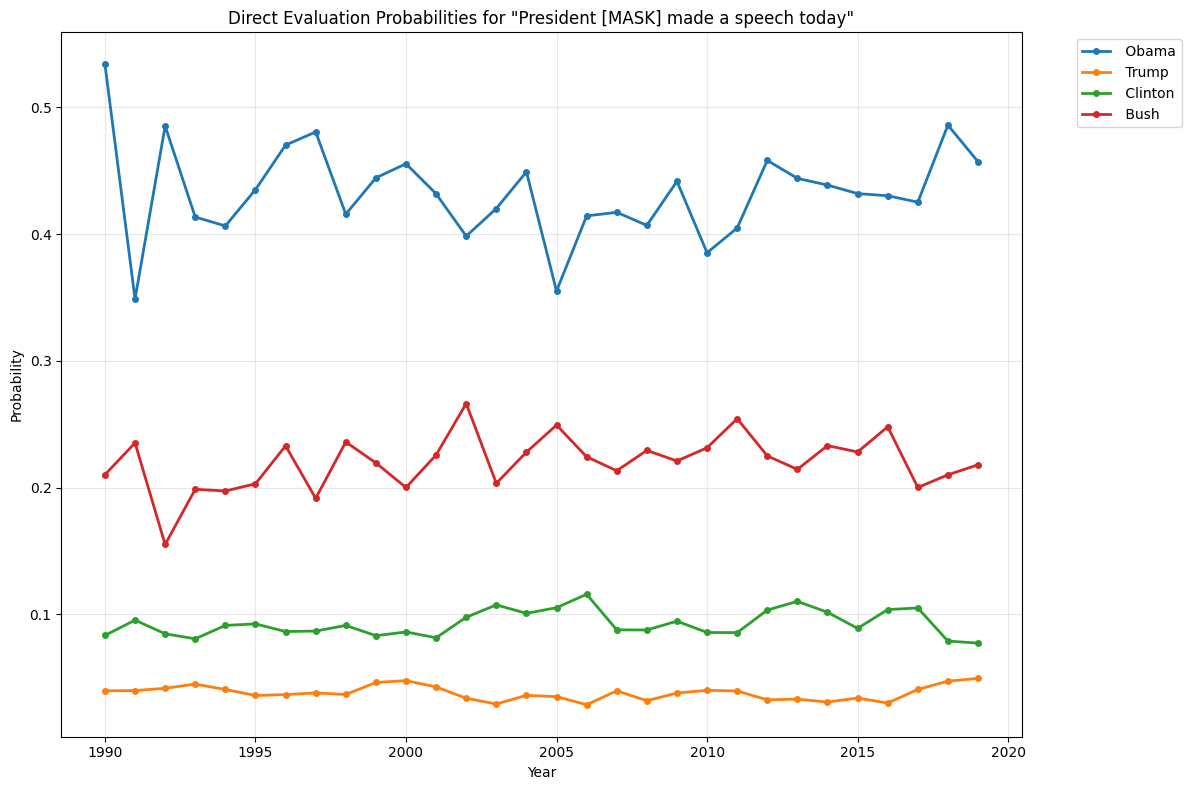

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract all unique words and their probabilities by year
word_probs_by_year = defaultdict(dict)
all_words = set()

for year_idx, results in enumerate(all_results):
    year = 1990 + year_idx
    for word, prob in results:
        word_probs_by_year[word][year] = prob
        all_words.add(word)

# Create the plot
plt.figure(figsize=(12, 8))
years = list(range(1990, 2020))

for word in all_words:
    probs = []
    for year in years:
        # Use 0 if word doesn't have probability for this year
        prob = word_probs_by_year[word].get(year, 0)
        probs.append(prob)
    
    plt.plot(years, probs, marker='o', label=word, linewidth=2, markersize=4)

plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Direct Evaluation Probabilities for "President [MASK] made a speech today"')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Saved figure to presidents_comparison.png


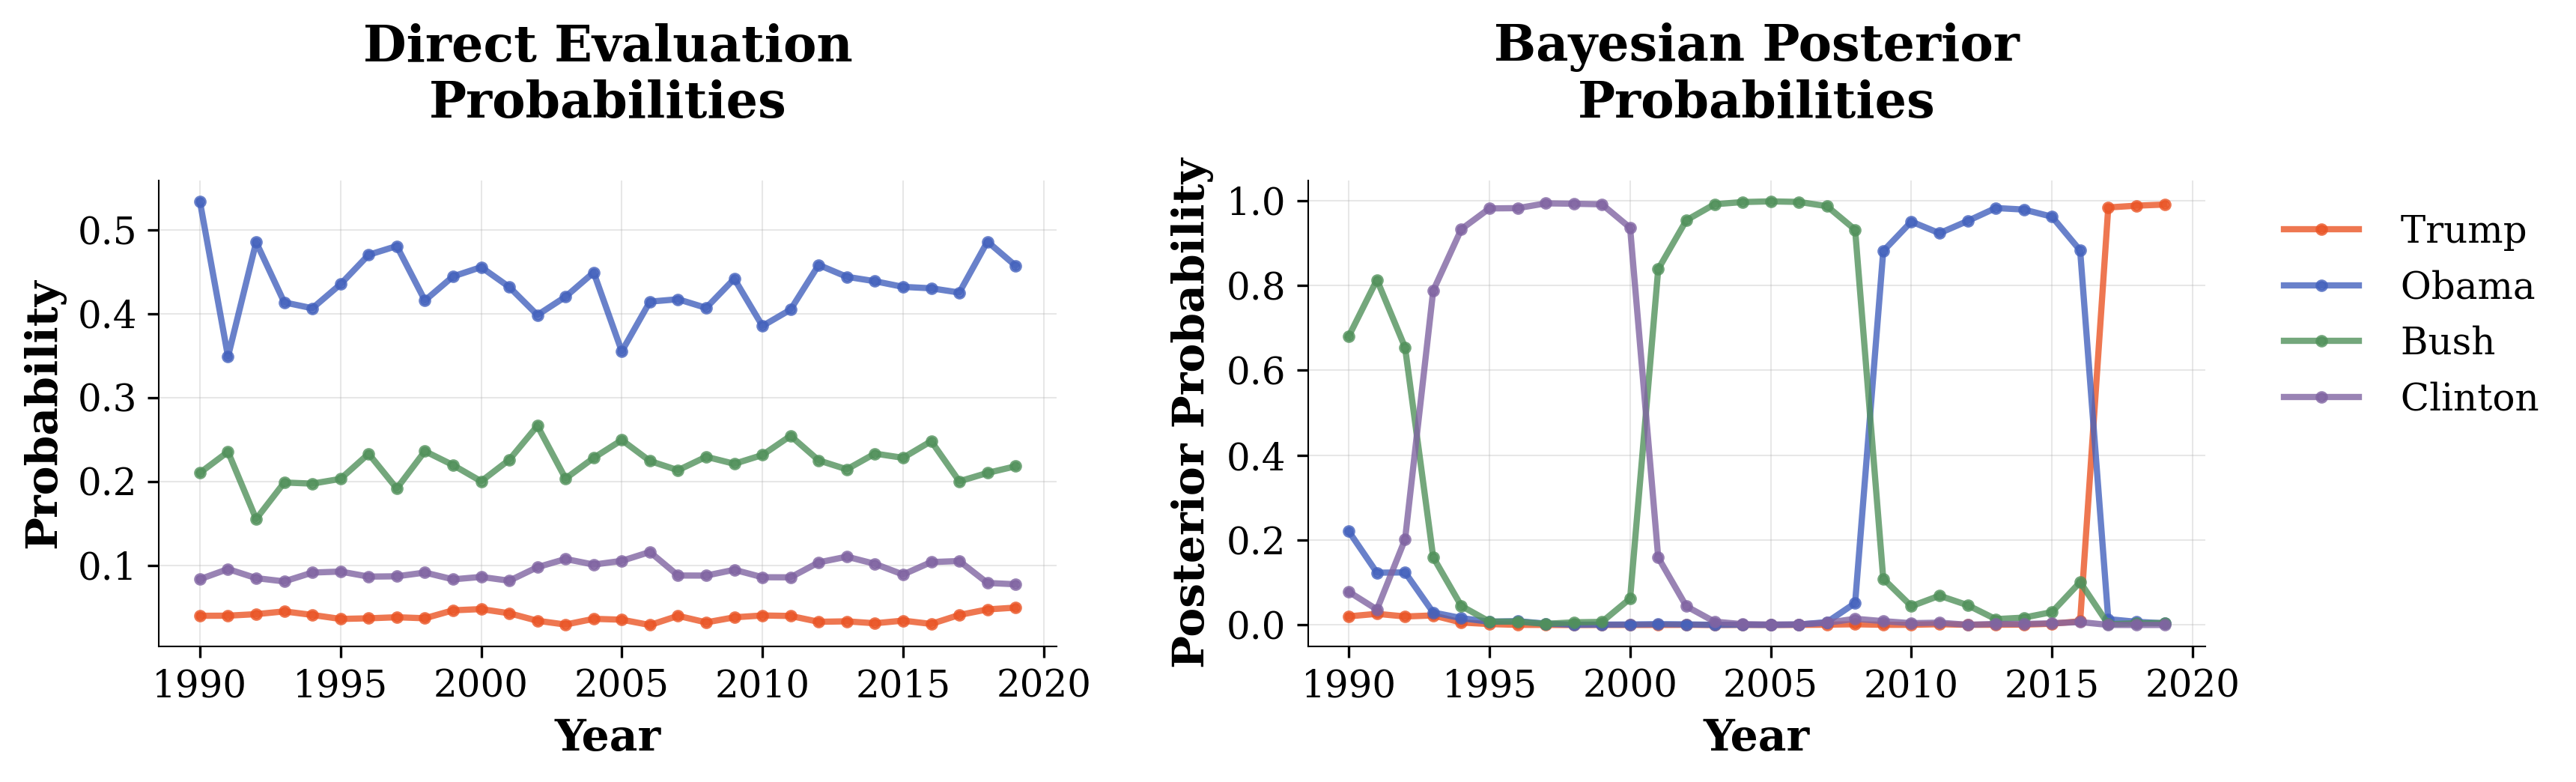

In [13]:
# Create a two-panel figure comparing direct and posterior probabilities
# This is the figure for the paper - styled to match visualize_process_small

import matplotlib.pyplot as plt
import numpy as np

# Create figure optimized for two-column manuscript layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=300)  # Two-column width, high DPI

# Use consistent color palette
pres_to_color = {' Trump': '#EA5526', ' Obama': '#4462BD', ' Bush': '#51915B', ' Clinton': '#8064A2'}
years = list(range(1990, 2020))

# Left panel: Direct probabilities
for word in all_words:
    probs = []
    for year in years:
        prob = word_probs_by_year[word].get(year, 0)
        probs.append(prob)
    
    ax1.plot(years, probs, marker='o', label=word, linewidth=2, markersize=3, 
             color=pres_to_color[word], alpha=0.8)

# Style left panel
ax1.set_xlabel('Year', fontfamily='serif', fontsize=14, fontweight='bold')
ax1.set_ylabel('Probability', fontfamily='serif', fontsize=14, fontweight='bold')
ax1.set_title('Direct Evaluation\nProbabilities', fontfamily='serif', fontsize=16, fontweight='bold', pad=20)

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(0.5)
ax1.spines['bottom'].set_linewidth(0.5)

# Add subtle grid
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)

# Style ticks
ax1.tick_params(axis='both', which='major', labelsize=12)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontfamily('serif')

# Right panel: Posterior probabilities (Bayesian update)
all_bayes = np.stack([t_bayes, o_bayes, b_bayes, c_bayes])
posteriors = all_bayes/np.sum(all_bayes, axis=0)
posterior_words = [' Trump', ' Obama', ' Bush', ' Clinton']

for i, word in enumerate(posterior_words):
    ax2.plot(years, posteriors[i], marker='o', label=word, linewidth=2, markersize=3, 
             color=pres_to_color[word], alpha=0.8)

# Style right panel
ax2.set_xlabel('Year', fontfamily='serif', fontsize=14, fontweight='bold')
ax2.set_ylabel('Posterior Probability', fontfamily='serif', fontsize=14, fontweight='bold')
ax2.set_title('Bayesian Posterior\nProbabilities', fontfamily='serif', fontsize=16, fontweight='bold', pad=20)

# Remove top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.5)

# Add subtle grid
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)

# Style ticks
ax2.tick_params(axis='both', which='major', labelsize=12)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontfamily('serif')

# Add legend to right panel
legend = ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, frameon=False)
for text in legend.get_texts():
    text.set_fontfamily('serif')

# Tight layout and save
plt.tight_layout()

# Save as PNG with high DPI for manuscript
plt.savefig('presidents_comparison.png', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
print("Saved figure to presidents_comparison.png")

plt.show()


In [12]:
# Create a two-panel figure comparing direct and posterior probabilities using Plotly

import plotly.graph_objects as go
from plotly.subplots import make_subplots

pres_to_color = {' Trump': '#EA5526', ' Obama': '#4462bd', ' Bush': '#51915B', ' Clinton': '#8064A2'}
years = list(range(1990, 2020))

# Create subplots with two panels
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Direct Evaluation Probabilities<br>"President [MASK] made a speech today"',
                   'Bayesian Posterior Probabilities<br>"President [MASK] made a speech today"'),
    horizontal_spacing=0.1,
    vertical_spacing=0.15,
)

# Left panel: Direct probabilities
for word in all_words:
    probs = []
    for year in years:
        prob = word_probs_by_year[word].get(year, 0)
        probs.append(prob)
    
    fig.add_trace(
        go.Scatter(
            x=years, 
            y=probs, 
            mode='lines+markers',
            name=word,
            line=dict(color=pres_to_color[word], width=2),
            marker=dict(size=6),
            showlegend=True,
            legendgroup=word,
            hovertemplate='<span style="font-family: Geist Mono;"><b>' + word + '</b><br> Year: %{x}<br> Posterior Probability: %{y:.4f}<extra></extra></span>',
            hoverlabel=dict(namelength=-1)
        ),
        row=1, col=1
    )

# Right panel: Posterior probabilities (Bayesian update)
all_bayes = np.stack([t_bayes, o_bayes, b_bayes, c_bayes])
posteriors = all_bayes/np.sum(all_bayes, axis=0)
posterior_words = [' Trump', ' Obama', ' Bush', ' Clinton']

for i, word in enumerate(posterior_words):
    fig.add_trace(
        go.Scatter(
            x=years, 
            y=posteriors[i], 
            mode='lines+markers',
            name=word,
            line=dict(color=pres_to_color[word], width=2),
            marker=dict(size=6),
            showlegend=False,
            legendgroup=word,
            hovertemplate='<span style="font-family: Geist Mono;"><b>' + word + '</b><br> Year: %{x}<br> Posterior Probability: %{y:.4f}<extra></extra></span>',
            hoverlabel=dict(namelength=-1)
        ),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    font=dict(family="Junicode", size=16, color='black'),
    height=400,
    width=1200,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    hovermode='closest',
    legend=dict(
        x=1.02,
        y=1,
        bgcolor='rgba(0,0,0,0)',
        font=dict(family="Junicode", size=16, color='black')
    )
)

# Update x and y axes with matching y-axis ranges
fig.update_xaxes(title_text="Year", title_font=dict(family="Junicode", size=18, color='black'), tickfont=dict(family="Geist Mono", size=14, color='black'), showgrid=False, linecolor='black', linewidth=1, zeroline=False)
fig.update_yaxes(title_text="Probability", title_font=dict(family="Junicode", size=18, color='black'), tickfont=dict(family="Geist Mono", size=14, color='black'), showgrid=False, linecolor='black', linewidth=1, range=[0, 1.1], zeroline=False, row=1, col=1)
fig.update_yaxes(title_text="Posterior Probability", title_font=dict(family="Junicode", size=18, color='black'), tickfont=dict(family="Geist Mono", size=14, color='black'), showgrid=False, linecolor='black', linewidth=1, range=[0, 1.1], zeroline=False, row=1, col=2)

# Update subplot titles to use Junicode font and add more spacing
fig.update_annotations(font=dict(family="Junicode", size=20, color='black'), y=1.05)

# Hide the toolbar
config = {'displayModeBar': False}
fig.show(config=config)

# Save the figure as HTML
fig.write_html("presidents.html", config=config)
